In [22]:
# Ensure a GPU-compatible PyTorch build for RTX 50-series
# If you still see CUDA kernel errors, re-run this cell and restart the kernel.
import sys, subprocess

def pip_install(args):
    print('Installing:', ' '.join(args))
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *args])

try:
    # Try nightly cu130 wheels (newest GPU arch support)
    pip_install(['--pre', '--upgrade', 'torch', 'torchvision', '--index-url', 'https://download.pytorch.org/whl/nightly/cu130'])
except Exception as e:
    print('Nightly cu130 install failed, trying stable cu126...')
    pip_install(['--upgrade', 'torch', 'torchvision', '--index-url', 'https://download.pytorch.org/whl/cu126'])

import torch
print('Torch:', torch.__version__, '| CUDA:', torch.version.cuda)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0), '| Capability:', torch.cuda.get_device_capability(0))
else:
    print('GPU not available; will run on CPU.')


Installing: --pre --upgrade torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu130
Torch: 2.9.1+cu126 | CUDA: 12.6
CUDA available: True
Device: NVIDIA GeForce RTX 5060 | Capability: (12, 0)


# IoT Network Intrusion Detection using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify network traffic as **Normal** or **Anomaly** using the IoT Network Intrusion Dataset.

In [23]:
# Optional: install GPU-enabled PyTorch (RTX 5060 uses CUDA 12.6 wheels)
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126


## 1. Import Required Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import warnings
warnings.filterwarnings('ignore')

def get_device():
    # Attempt a small CUDA op to ensure kernels exist; fallback to CPU on failure.
    if torch.cuda.is_available():
        try:
            x = torch.randn(1, 1, 16, device='cuda')
            nn.Conv1d(1, 1, 3, padding=1).cuda()(x)
            return torch.device('cuda')
        except Exception as e:
            print(f"CUDA test failed, using CPU instead: {e}")
            return torch.device('cpu')
    return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"PyTorch version: {torch.__version__}")


CUDA test failed, using CPU instead: CUDA error: no kernel image is available for execution on the device
Search for `cudaErrorNoKernelImageForDevice' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using device: cpu
PyTorch version: 2.9.1+cu126


## 2. Load and Explore Dataset

In [25]:
# Load the dataset
df = pd.read_csv("D:\\Dataset\\archive\\IoT Network Intrusion Dataset.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (625783, 86)

First few rows:
                                     Flow_ID           Src_IP  Src_Port  \
0   192.168.0.13-192.168.0.16-10000-10101-17     192.168.0.13     10000   
1    192.168.0.13-222.160.179.132-554-2179-6  222.160.179.132      2179   
2     192.168.0.13-192.168.0.16-9020-52727-6     192.168.0.16     52727   
3     192.168.0.13-192.168.0.16-9020-52964-6     192.168.0.16     52964   
4  192.168.0.1-239.255.255.250-36763-1900-17      192.168.0.1     36763   

            Dst_IP  Dst_Port  Protocol               Timestamp  Flow_Duration  \
0     192.168.0.16     10101        17  25/07/2019 03:25:53 AM             75   
1     192.168.0.13       554         6  26/05/2019 10:11:06 PM           5310   
2     192.168.0.13      9020         6  11/07/2019 01:24:48 AM            141   
3     192.168.0.13      9020         6  04/09/2019 03:58:17 AM            151   
4  239.255.255.250      1900        17  10/09/2019 01:41:18 AM            153   

   Tot_Fwd_Pkts  

In [26]:
# Check target column (assuming it's named 'Label', 'Cat', or similar)
# Identify the target column - typically the last column or one containing attack types
target_column = None
for col in ['Label', 'Cat', 'label', 'cat', 'Attack_type', 'Class']:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    # Assume last column is the target
    target_column = df.columns[-1]

print(f"Target column: {target_column}")
print(f"\nClass distribution:")
print(df[target_column].value_counts())
print(f"\nUnique values in target: {df[target_column].unique()}")

Target column: Label

Class distribution:
Label
Anomaly    585710
Normal      40073
Name: count, dtype: int64

Unique values in target: ['Anomaly' 'Normal']


## 3. Data Preprocessing

Binary label distribution:
binary_label
1    585710
0     40073
Name: count, dtype: int64

Normal: 40073
Anomaly: 585710


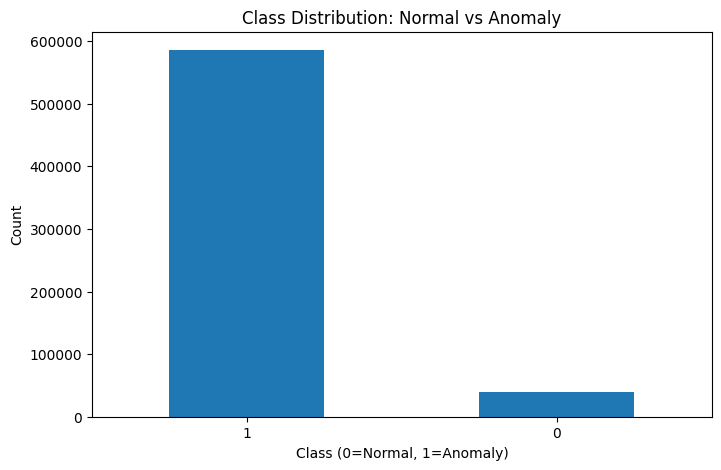

In [27]:
# Convert target to binary: Normal (0) vs Anomaly (1)
# Assuming any attack type is anomaly and 'Normal' or similar is normal
df['binary_label'] = df[target_column].apply(
    lambda x: 0 if str(x).lower() in ['normal', '0', 'benign'] else 1
)

print("Binary label distribution:")
print(df['binary_label'].value_counts())
print(f"\nNormal: {(df['binary_label'] == 0).sum()}")
print(f"Anomaly: {(df['binary_label'] == 1).sum()}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['binary_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution: Normal vs Anomaly')
plt.xlabel('Class (0=Normal, 1=Anomaly)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [28]:
# Separate features and target
X = df.drop([target_column, 'binary_label'], axis=1)
y = df['binary_label']

# Handle non-numeric columns
# Identify numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Non-numeric columns: {len(non_numeric_cols)}")
print(f"\nNon-numeric columns: {non_numeric_cols[:10]}")  # Show first 10

# Encode non-numeric columns
if non_numeric_cols:
    le = LabelEncoder()
    for col in non_numeric_cols:
        X[col] = le.fit_transform(X[col].astype(str))

# Handle missing values
X = X.fillna(0)

print(f"\nFinal feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

Numeric columns: 79
Non-numeric columns: 6

Non-numeric columns: ['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Cat', 'Sub_Cat']

Final feature shape: (625783, 85)
Target shape: (625783,)


In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: (500626, 85)
Testing set size: (125157, 85)

Training set class distribution:
binary_label
1    468568
0     32058
Name: count, dtype: int64

Testing set class distribution:
binary_label
1    117142
0      8015
Name: count, dtype: int64


In [30]:
# Check for infinite values and replace them
print("Checking for infinite values...")
print(f"Infinite values in X_train: {np.isinf(X_train).sum().sum()}")
print(f"Infinite values in X_test: {np.isinf(X_test).sum().sum()}")

# Replace infinite values with NaN, then fill with 0
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Check for very large values and clip them
print("\nChecking for very large values...")
print(f"Max value in X_train: {X_train.max().max()}")
print(f"Min value in X_train: {X_train.min().min()}")

# Clip extreme values to a reasonable range
X_train = X_train.clip(-1e10, 1e10)
X_test = X_test.clip(-1e10, 1e10)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for PyTorch 1D CNN: (batch, channels=1, timesteps=features)
X_train_cnn = np.expand_dims(X_train_scaled, axis=1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=1)
input_length = X_train_cnn.shape[2]

print(f"\nReshaped training data: {X_train_cnn.shape}")
print(f"Reshaped testing data: {X_test_cnn.shape}")
print(f"Input length (timesteps): {input_length}")


Checking for infinite values...
Infinite values in X_train: 604
Infinite values in X_test: 132

Checking for very large values...
Max value in X_train: 4066000000.0
Min value in X_train: -1.0

Reshaped training data: (500626, 1, 85)
Reshaped testing data: (125157, 1, 85)
Input length (timesteps): 85


## 4. Build CNN Model

In [31]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Train/validation split from the training set
full_train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.2 * len(full_train_ds))
train_size = len(full_train_ds) - val_size
train_ds, val_ds = random_split(
    full_train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_ds = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class IoTCNN(nn.Module):
    def __init__(self, input_length: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),  # avoid manual flatten length math
            nn.Dropout(0.4)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = IoTCNN(input_length).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)


IoTCNN(
  (features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AdaptiveMaxPool1d(output_size=1)
    (14): Dropout(p=0.4, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, o

## 5. Train the Model (PyTorch, 10 Epochs)


In [32]:
def batch_accuracy(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    return (preds == labels).float().mean().item()

EPOCHS = 10
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    batches = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += batch_accuracy(logits, yb)
        batches += 1
    train_loss = running_loss / batches
    train_acc = running_acc / batches

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_batches = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze()
            loss = criterion(logits, yb)
            val_loss += loss.item()
            val_acc += batch_accuracy(logits, yb)
            val_batches += 1
    val_loss /= max(1, val_batches)
    val_acc /= max(1, val_batches)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

print("\nTraining completed!")


Starting training...
Epoch 01 | Train Loss 0.0195 | Val Loss 0.0008 | Train Acc 99.39% | Val Acc 99.99%
Epoch 02 | Train Loss 0.0036 | Val Loss 0.0005 | Train Acc 99.92% | Val Acc 99.99%
Epoch 03 | Train Loss 0.0029 | Val Loss 0.0008 | Train Acc 99.94% | Val Acc 99.99%
Epoch 04 | Train Loss 0.0021 | Val Loss 0.0002 | Train Acc 99.96% | Val Acc 99.99%
Epoch 05 | Train Loss 0.0017 | Val Loss 0.7737 | Train Acc 99.96% | Val Acc 87.93%
Epoch 06 | Train Loss 0.0016 | Val Loss 0.0003 | Train Acc 99.96% | Val Acc 99.99%
Epoch 07 | Train Loss 0.0016 | Val Loss 0.0004 | Train Acc 99.97% | Val Acc 99.99%
Epoch 08 | Train Loss 0.0016 | Val Loss 0.0001 | Train Acc 99.97% | Val Acc 100.00%
Epoch 09 | Train Loss 0.0013 | Val Loss 0.0000 | Train Acc 99.97% | Val Acc 100.00%
Epoch 10 | Train Loss 0.0010 | Val Loss 0.0000 | Train Acc 99.98% | Val Acc 100.00%

Training completed!


## 6. Visualize Training History

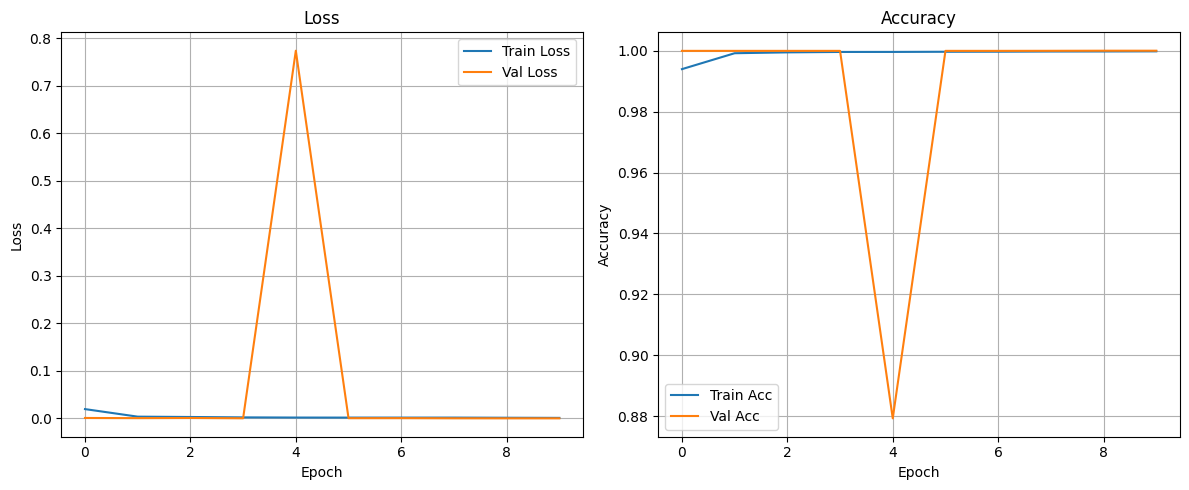

In [33]:
# Plot training history (PyTorch)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_loss_hist, label='Train Loss')
axes[0].plot(val_loss_hist, label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_acc_hist, label='Train Acc')
axes[1].plot(val_acc_hist, label='Val Acc')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 7. Model Evaluation

In [34]:
# Evaluate on test set
model.eval()
test_loss = 0.0
test_acc = 0.0
test_batches = 0
all_logits = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        test_loss += loss.item()
        test_acc += batch_accuracy(logits, yb)
        test_batches += 1
        all_logits.append(logits.cpu())
        all_labels.append(yb.cpu())

test_loss /= max(1, test_batches)
test_acc /= max(1, test_batches)
all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

print(f"\n{'='*50}")
print("Test Results:")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")



Test Results:
Test Loss: 0.0001
Test Accuracy: 1.0000 (100.00%)


In [35]:
# Make predictions
probs = torch.sigmoid(all_logits).numpy()
y_pred = (probs > 0.5).astype(int).flatten()
y_true = all_labels.numpy().astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

# Calculate F1-Score
f1 = f1_score(y_true, y_pred)
print(f"\nF1-Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      8015
     Anomaly       1.00      1.00      1.00    117142

    accuracy                           1.00    125157
   macro avg       1.00      1.00      1.00    125157
weighted avg       1.00      1.00      1.00    125157


F1-Score: 1.0000


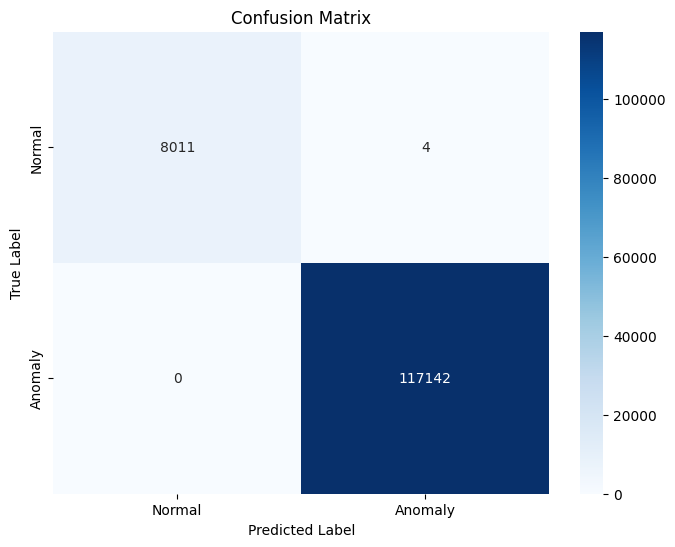


Confusion Matrix:
True Negatives (Normal predicted as Normal): 8011
False Positives (Normal predicted as Anomaly): 4
False Negatives (Anomaly predicted as Normal): 0
True Positives (Anomaly predicted as Anomaly): 117142


In [36]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display confusion matrix values
print("\nConfusion Matrix:")
print(f"True Negatives (Normal predicted as Normal): {cm[0, 0]}")
print(f"False Positives (Normal predicted as Anomaly): {cm[0, 1]}")
print(f"False Negatives (Anomaly predicted as Normal): {cm[1, 0]}")
print(f"True Positives (Anomaly predicted as Anomaly): {cm[1, 1]}")


## Summary

This notebook now uses a PyTorch 1D CNN for IoT Network Intrusion Detection with the following features:

- **Binary Classification**: Normal vs Anomaly
- **Model Architecture**: 3 Conv1D blocks with BatchNorm, Dropout, AdaptiveMaxPool1d, followed by dense layers
- **Training**: 10 epochs with validation split, Adam optimizer, BCEWithLogitsLoss
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, and Confusion Matrix
- **Data Processing**: StandardScaler normalization, train/val/test loaders, and window-free feature timelines treated as 1D sequences

The PyTorch model runs on GPU if available (RTX 5060), otherwise falls back to CPU.


In [37]:
# PyTorch GPU diagnostics
import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    print("Device count:", torch.cuda.device_count())
    print("CUDA capability:", torch.cuda.get_device_capability(0))


PyTorch: 2.9.1+cu126
CUDA available: True
Device: NVIDIA GeForce RTX 5060
Device count: 1
CUDA capability: (12, 0)
